In [1]:
%matplotlib inline

In [2]:
import os
dirname = "/Users/aphearin/Dropbox/protoDC2"
sdss_basename = "volume_complete_sdss.hdf5"
umachine_z0_basename = "value_added_umachine_sfr_catalog_1.002310.hdf5"
umachine_z1_basename = "value_added_umachine_sfr_catalog_0.501122.hdf5"
protoDC2_basename = "value_added_protoDC2_snapnum_487.hdf5"

from astropy.table import Table
sdss = Table.read(os.path.join(dirname, sdss_basename), path='data')
protoDC2_z0 = Table.read(os.path.join(dirname, protoDC2_basename), path='data')

from rescale_dc2.load_catalogs import load_closest_available_umachine_catalog
umachine_z0 = load_closest_available_umachine_catalog(0.)
umachine_z1 = load_closest_available_umachine_catalog(1.)

print(protoDC2_z0.keys())

['totalLuminositiesStellar:SDSS_r:observed', 'diskLuminositiesStellar:SDSS_r:observed', 'spheroidLuminositiesStellar:SDSS_r:observed', 'totalLuminositiesStellar:SDSS_g:observed', 'diskLuminositiesStellar:SDSS_g:observed', 'spheroidLuminositiesStellar:SDSS_g:observed', 'infallHaloMass', 'hostHaloMass', 'hostIndex', 'isCentral', 'spheroidMassStellar', 'totalMassStellar', 'galaxyID', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'totalStarFormationRate', 'mstar_percentile_fixed_infallHaloMass']


In [3]:
print(umachine_z0.keys())

['id', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'obs_sm', 'obs_sfr', 'mpeak', 'mvir', 'vmax', 'vmax_at_mpeak', 'upid', 'hostid', 'host_halo_is_in_catalog', 'host_halo_mvir', 'host_halo_vmax', 'obs_ssfr']


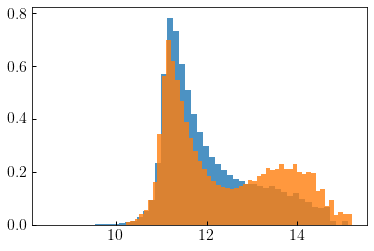

In [4]:
fig, ax = plt.subplots(1, 1)

__=ax.hist(np.log10(umachine_z0['host_halo_mvir']), bins=50, normed=True, alpha=0.8)
__=ax.hist(np.log10(protoDC2_z0['hostHaloMass']), bins=50, normed=True, alpha=0.8)

In [21]:
from galsampler import halo_bin_indices
mhost_bins = np.logspace(10, 14.75, 25)
protoDC2_z0['host_mass_bin'] = halo_bin_indices(
    mass=(protoDC2_z0['hostHaloMass'], mhost_bins))
umachine_z0['host_mass_bin'] = halo_bin_indices(
    mass=(umachine_z0['host_halo_mvir'], mhost_bins))

from galsampler import matching_bin_dictionary

nmin = 50
bin_shapes = mhost_bins.shape
cenmask = umachine_z0['upid'] == -1
central_bin_correspondence = matching_bin_dictionary(
    umachine_z0['host_mass_bin'][cenmask], nmin, bin_shapes)
satellite_bin_correspondence = matching_bin_dictionary(
    umachine_z0['host_mass_bin'][~cenmask], nmin, bin_shapes)

In [30]:
ibin = 8

pdc2_cenmask = protoDC2_z0['isCentral']==True
pdc2_ibin_mask = protoDC2_z0['host_mass_bin'] == ibin

um_cenmask = umachine_z0['upid']==-1
um_ibin_cenmask = umachine_z0['host_mass_bin']==central_bin_correspondence[ibin]
um_ibin_satmask = umachine_z0['host_mass_bin']==satellite_bin_correspondence[ibin]


num_cens_pdc2 = np.count_nonzero(pdc2_cenmask & pdc2_ibin_mask)
num_sats_pdc2 = np.count_nonzero(~pdc2_cenmask & pdc2_ibin_mask)

from halotools.empirical_models import conditional_abunmatch

remapped_central_mstar_ibin = conditional_abunmatch(
    protoDC2_z0['totalMassStellar'][pdc2_cenmask & pdc2_ibin_mask], 
    umachine_z0['obs_sm'][um_cenmask & um_ibin_cenmask])

remapped_satellite_mstar_ibin = conditional_abunmatch(
    protoDC2_z0['totalMassStellar'][~pdc2_cenmask & pdc2_ibin_mask], 
    umachine_z0['obs_sm'][~um_cenmask & um_ibin_satmask])

